# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
datdir = os.getenv("PUIDATA") + "/Lab9" # On my local machine
# datdir = os.getenv("HOME") + "/PUIdata" # For use on compute where the PUIDATA variable is unavailable
shape_path = datdir + "/Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Skip visualization of boroughs, which was done in Assignment 1

### Load NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data = DataFrame.from_csv(datdir + '/Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
#SE_T002_002 is population density in social explorer dataset
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']])

#### Skip visualization of the Population density for 2010, which was done in Assignment 1

## Explore CitiBike data

### Load CitiBike data

In [7]:
df_bike_monthly = DataFrame.from_csv(datdir + '/Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


Table 1a. The monthly ride totals by station number.

In [8]:
df_bike_monthly_nan = df_bike_monthly.replace(0, np.nan)
df_bike_monthly_nan.head(5)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914.0,6979,2750,4914,2229,2183,3139,3622.0,2368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,2696,4429.0,9020,3433,6645,2768,2761,3422,4271.0,2910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-30,2878,5258.0,9814,3739,7837,3206,2747,3590,4618.0,2885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-31,2920,4409.0,10456,3520,8928,3237,2530,3909,4169.0,2542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-30,1883,2731.0,6384,2446,5201,2085,1415,2727,3146.0,1539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table 1b. The monthly ride totals by station number with 0s replaced with NaN. This will allow calculating averages that exclude months for which the station was not in use.

### Time Series Aanalysis

In [9]:
df_bike_monthly_nan.tail(5)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2016-02-29,1200,1951.0,4913,2088,2503,2224,859,2814,NaN,1082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,1891,3181.0,7721,2529,4586,3692,1633,4015,NaN,1894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,2388,3833.0,7666,3219,5327,4157,1794,4169,NaN,1928,...,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,2808,6253.0,9246,4317,5920,5033,2109,5179,NaN,2459,...,901.0,62.0,20.0,2859.0,394.0,NaN,NaN,NaN,NaN,NaN
2016-06-30,3399,7370.0,10130,4566,7420,5775,2429,6037,NaN,3054,...,1036.0,NaN,NaN,7009.0,1109.0,665.0,2470.0,178.0,852.0,615.0


Table 1c. Monthly ride totals by station number at the end of the time period.

/home/scott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

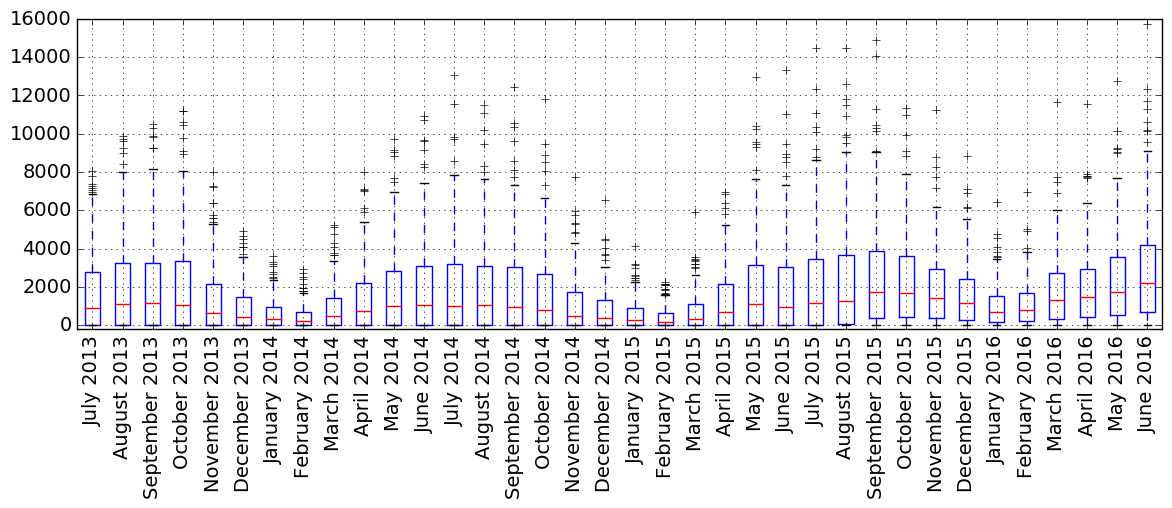

In [10]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize=(14, 4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15, 7), ax=ax, rot=90);
ax.set_ylim([-200, 16000])

Figure 1. Bar chart showing ridership by month.

#### Seasonal Decomposition

/home/scott/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


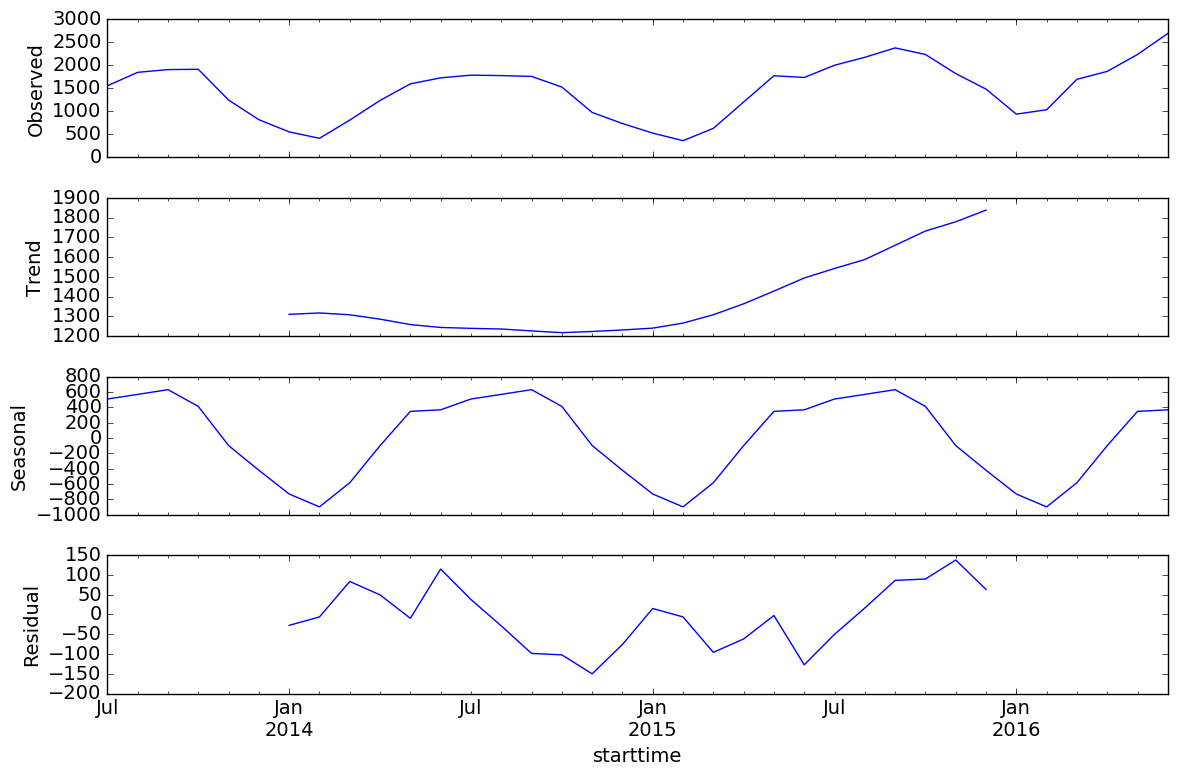

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 2. Breaking apart the components of monthly ridership: trend or year-to-year growth, seasonal variation, and residual.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id = DataFrame.from_csv(datdir + '/Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


Table 2. Coordinates of the first 5 stations.

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [13]:
import shapely
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


Table 3. Coordinates of the first 5 stations converted to type geometric point.

### Intersect the two geometries

In [14]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%", str((i + 1) * 100. / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [15]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [16]:
### Create average monthly rides column for summer and winter from monthly citibike data
### and add it to the station id which has the geometry
df_bike_summer = df_bike_monthly_nan[(df_bike_monthly_nan.index.month >= 6) &
                                     (df_bike_monthly_nan.index.month <= 8)]
df_bike_winter = df_bike_monthly_nan[df_bike_monthly_nan.index.month <= 3]
station_id['Winter'] = df_bike_winter.mean(skipna=True)
station_id['Summer'] = df_bike_summer.mean(skipna=True)

In [17]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Winter,Summer
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,993.222222,2491.333333
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1776.166667,4108.625000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4139.666667,9708.333333
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1488.222222,3668.666667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2368.888889,6654.444444


Table 4. First 5 stations with coordinate, borough/census tract, total rides, and average monthly rides.

### Add the monthly average rides to the CT shapefile 

In [18]:
# use the station_id and ct_shape DataFrames to combine seasonal ridership with geography
temp = station_id[['Winter', 'Summer']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0, inplace=True)

/home/scott/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Removing the CTs that are out of zoom boundries

In [19]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [20]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.Winter)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides by season

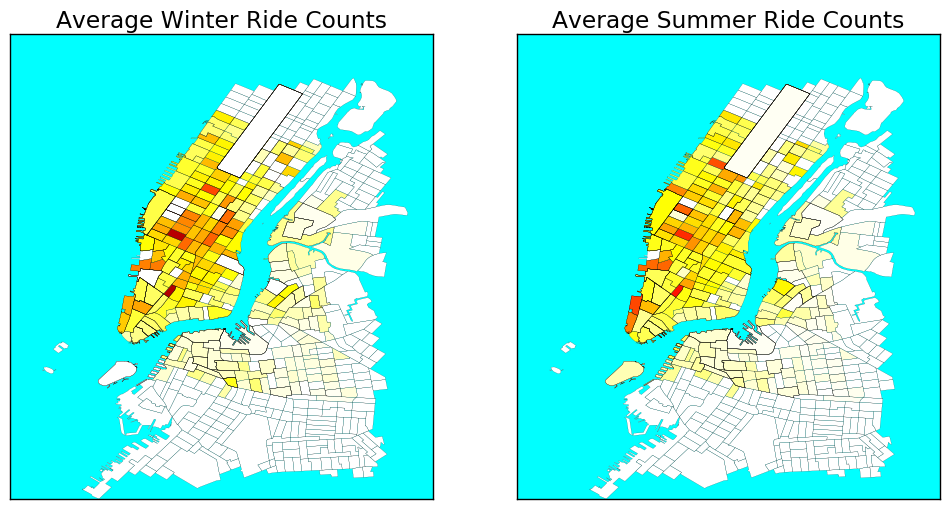

In [22]:
plt.rcParams['axes.facecolor'] = 'aqua'
axs = [None, None]
collist = ['Winter', 'Summer']
desclist = ['Average Winter Ride Counts', 'Average Summer Ride Counts']
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(12, 6))
for i in 0, 1:
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    ct_shape_MonthlyAve_Zoom.plot(column=collist[i], colormap='hot_r', alpha=1, linewidth=0.1, ax=axs[i])
    axs[i].set_title(desclist[i])

Figure 3. Winter ride counts (left) and summer ride counts (right) by census tract. 

### Export Shapefile CTs in the CitiBike Zone

In [23]:
path = datdir + '/Output/ct_shape_Seasonal_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [24]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [25]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [26]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [27]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [28]:
Wmatrix, ids = qW_CT.full()

In [29]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [30]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [31]:
MonthlyRide = {}
MonthlyRideLag = {}
for k in collist:
    MonthlyRide[k] = ct_shape_MonthlyAve_Zoom[k]
    MonthlyRideLag[k] = ps.lag_spatial(qW_CT, MonthlyRide[k])

#### Create Quantiles for maping

In [32]:
MonthlyRideLagQ10 = {}
for typ in MonthlyRide.keys():
    MonthlyRideLagQ10[typ] = ps.Quantiles(MonthlyRideLag[typ], k=10)
MonthlyRideLagQ10

{'Summer':                   Quantiles                  
  
  Lower              Upper               Count
            x[i] <=    0.000               159
    0.000 < x[i] <=   24.643                 2
   24.643 < x[i] <=  328.995                78
  328.995 < x[i] <=  700.312                80
  700.312 < x[i] <= 1169.274                79
 1169.274 < x[i] <= 2039.889                80
 2039.889 < x[i] <= 2869.099                79
 2869.099 < x[i] <= 3674.334                80
 3674.334 < x[i] <= 4371.253                79
 4371.253 < x[i] <= 6109.956                80,
 'Winter':                   Quantiles                  
  
  Lower              Upper               Count
            x[i] <=    0.000               159
    0.000 < x[i] <=   13.095                 2
   13.095 < x[i] <=  146.562                78
  146.562 < x[i] <=  295.039                80
  295.039 < x[i] <=  430.438                79
  430.438 < x[i] <=  748.452                83
  748.452 < x[i] <= 1078.863     

#### Map the monthly rides lag

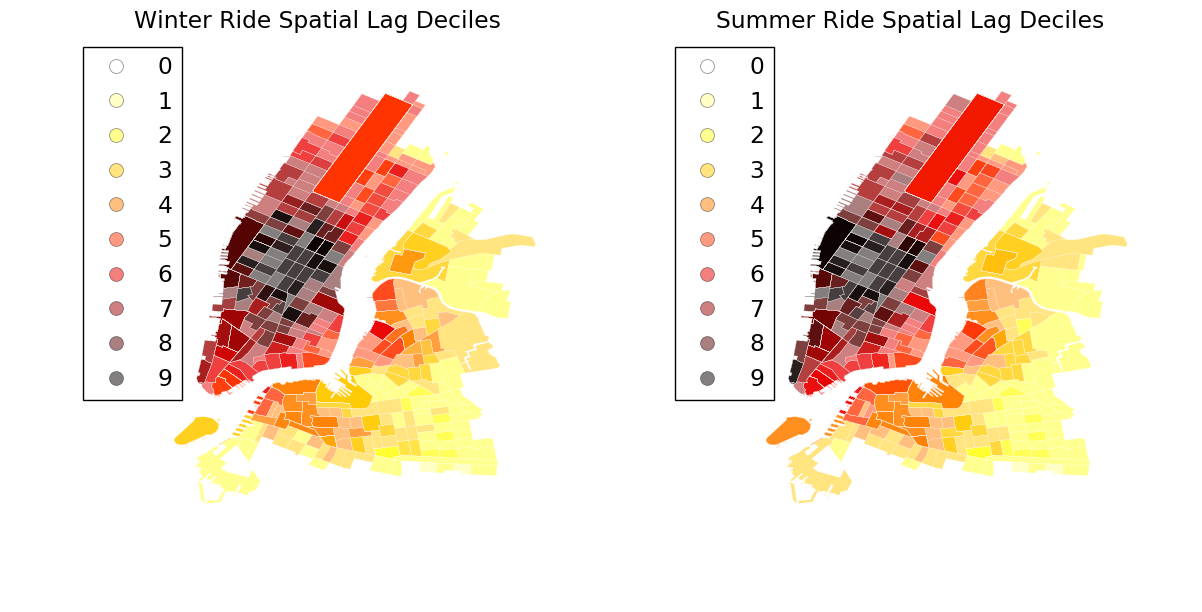

In [33]:
plt.rcParams['legend.facecolor'] = 'white'
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10[collist[i]].yb).plot(column='cl', categorical=True, 
            k=10, cmap='hot_r', linewidth=0.1, ax=axs[i], 
            edgecolor='white', legend=True)
    axs[i].set_axis_off()
axs[0].set_title("Winter Ride Spatial Lag Deciles")
axs[1].set_title("Summer Ride Spatial Lag Deciles")


Figure 4. Spatial lag deciles by winter rides (left) and by summer monthly rides (right).

## Global  Spatial Autocorrelation

In [34]:
b = {}
a = {}
for typ in collist:
    b[typ], a[typ] = np.polyfit(MonthlyRide[typ], MonthlyRideLag[typ], 1)
b, a 

({'Summer': 0.6230597924168445, 'Winter': 0.62224552813823941},
 {'Summer': 699.58381959614792, 'Winter': 266.48736741970674})

### Moran Scatterplot

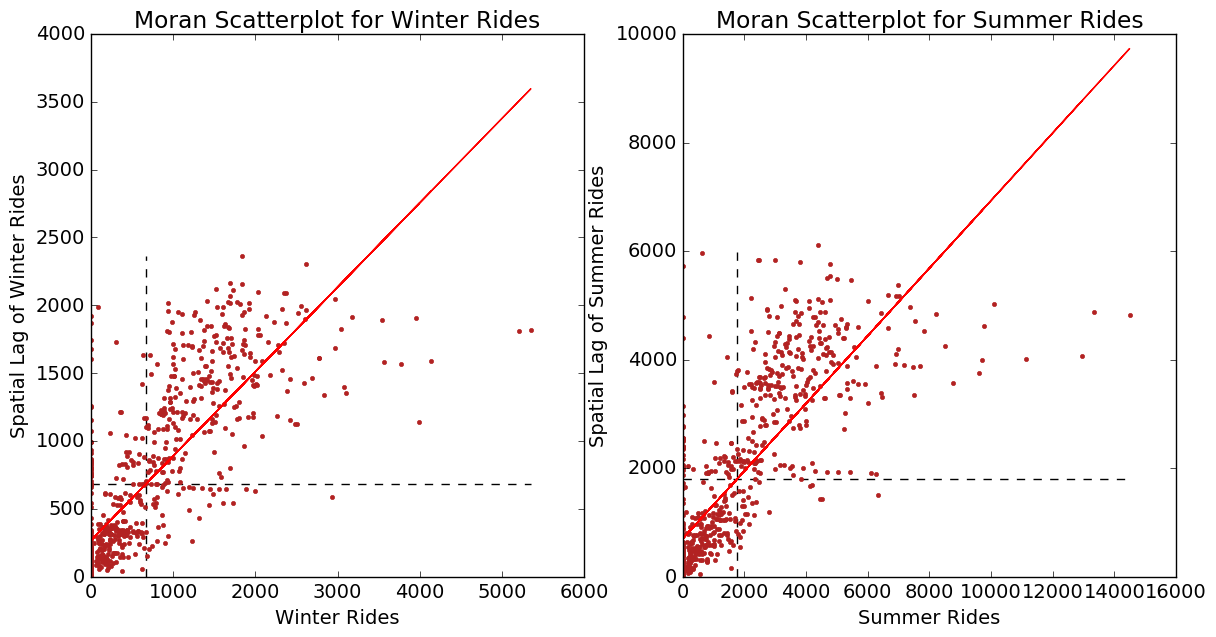

In [35]:
plt.rcParams['axes.facecolor'] = 'white'
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))

for i in 0, 1:
    axs[i].plot(MonthlyRide[collist[i]], MonthlyRideLag[collist[i]], '.', color='firebrick')

    # dashed vert at mean of the last year's PCI
    axs[i].vlines(MonthlyRide[collist[i]].mean(), MonthlyRideLag[collist[i]].min(),
                  MonthlyRideLag[collist[i]].max(), linestyle='--')
    # dashed horizontal at mean of lagged PCI
    axs[i].hlines(MonthlyRideLag[collist[i]].mean(), MonthlyRide[collist[i]].min(),
                  MonthlyRide[collist[i]].max(), linestyle='--')

    # red line of best fit using global I as slope
    axs[i].plot(MonthlyRide[collist[i]], a[collist[i]] + b[collist[i]] * MonthlyRide[collist[i]], 'r')
    axs[i].set_ylabel('Spatial Lag of {} Rides'.format(collist[i]))
    axs[i].set_xlabel('{} Rides'.format(collist[i]))
    axs[i].set_title('Moran Scatterplot for {} Rides'.format(collist[i]))
#axs[1].set_ylabel('Spatial Lag of Average Monthly Rides')
#axs[1].set_xlabel('Average MonthlyRides')
#axs[1].set_title("Moran Scatterplot for Average Rides")

Figure 5. Scatter plots of monthly rides against spatial lag of monthly rides with a trend line based on Moran's I for winter rides (left) and summer rides (right).

### Moran's I

In [36]:
I_MonthlyRide = {}
for typ in collist:
    I_MonthlyRide[typ] = ps.Moran(MonthlyRide[typ], qW_CT)

In [37]:
for typ in collist:
    print(typ)
    print(I_MonthlyRide[typ].I, I_MonthlyRide[typ].p_sim)

Winter
(0.62219031444180117, 0.001)
Summer
(0.62299701449245581, 0.001)


Thus, the $I$ statistic is $0.622$ for the winter rides and $0.623$ for summer rides. Both have a very small $p$ value. 

In [38]:
for typ in collist:
    print(typ)
    print(I_MonthlyRide[typ].sim[0:10])

Winter
[-0.00250025  0.0087399  -0.00439505 -0.00210794 -0.02888562  0.03266346
  0.02634905  0.01279825 -0.00175127 -0.00535088]
Summer
[-0.00844163  0.01478814 -0.01022888 -0.00495927 -0.02030695  0.0264339
 -0.00348996  0.00501124  0.01247521 -0.01096679]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [39]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

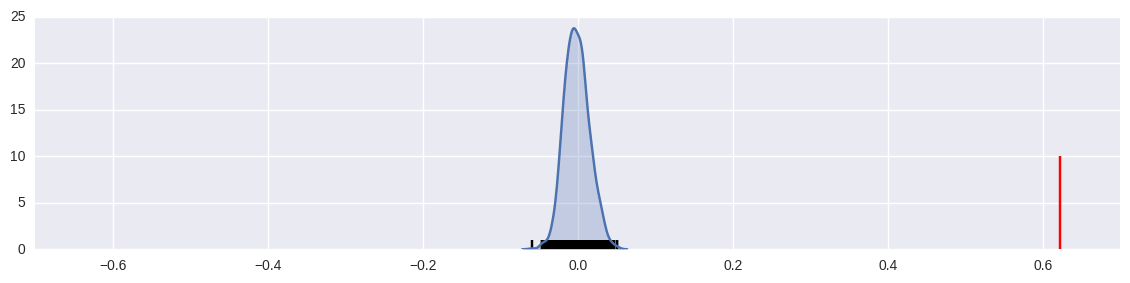

In [40]:
sns.kdeplot(I_MonthlyRide[collist[0]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[0]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[0]].I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 6a. Kernel density plot for winter ridership.

(-0.7, 0.7)

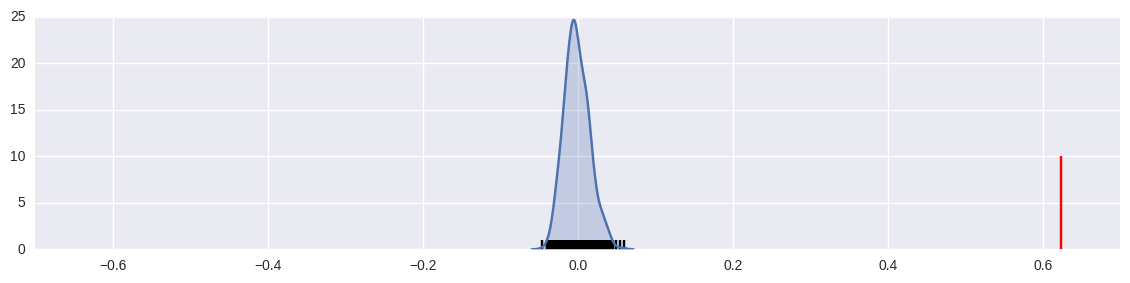

In [41]:
sns.kdeplot(I_MonthlyRide[collist[1]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[1]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[1]].I, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 6b. Kernel density plot for winter monthly ridership.

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

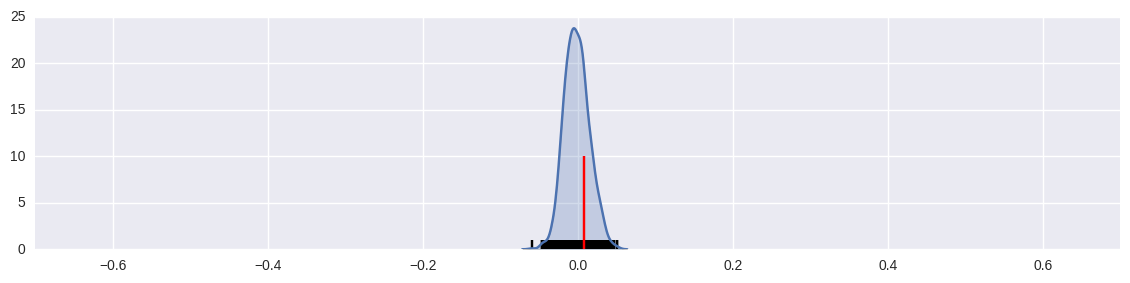

In [42]:
sns.kdeplot(I_MonthlyRide[collist[0]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[0]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[0]].EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 7a. Moran's $I$ fits within expected value for winter rides.

(-0.7, 0.7)

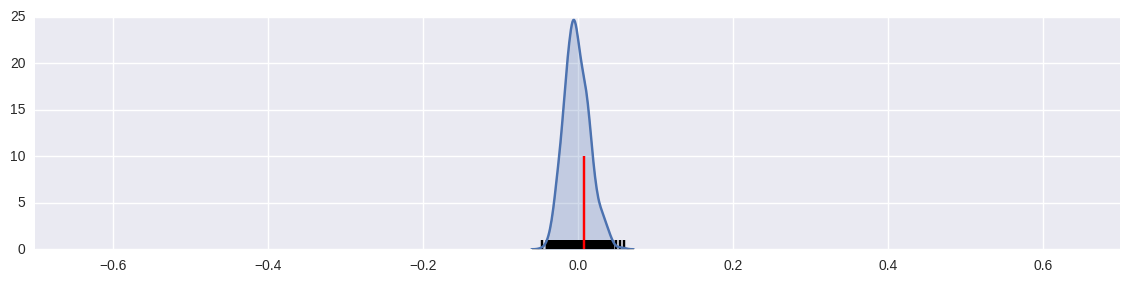

In [43]:
sns.kdeplot(I_MonthlyRide[collist[1]].sim, shade=True)
plt.vlines(I_MonthlyRide[collist[1]].sim, 0, 1)
plt.vlines(I_MonthlyRide[collist[1]].EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

Figure 7b. Moran's $I$ fits within expected value for summer rides.

## Local  Spatial Autocorrelation

In [44]:
LMo_MonthlyRide = {}
for typ in collist:
    LMo_MonthlyRide[typ] = ps.Moran_Local(MonthlyRide[typ], qW_CT, permutations=999)

In [45]:
for typ in collist:
    print(LMo_MonthlyRide[typ].Is[0:5], LMo_MonthlyRide[typ].p_sim[0:5])

(array([-0.        , -0.17106969,  0.03512457,  0.01125626, -0.14060416]), array([ 0.001,  0.272,  0.326,  0.311,  0.216]))
(array([-0.        , -0.08130227,  0.00852911,  0.02115068, -0.02303299]), array([ 0.001,  0.37 ,  0.359,  0.367,  0.355]))


### LISA (Local Indicators of Spatial Autocorrelation)

In [46]:
sigs = {}
W_sigs = {}
insigs = {}
W_insigs = {}
for typ in collist:
    sigs[typ] = MonthlyRide[typ][LMo_MonthlyRide[typ].p_sim <= .001]
    W_sigs[typ] = MonthlyRideLag[typ][LMo_MonthlyRide[typ].p_sim <= .001]
    insigs[typ] = MonthlyRide[typ][LMo_MonthlyRide[typ].p_sim > .001]
    W_insigs[typ] = MonthlyRideLag[typ][LMo_MonthlyRide[typ].p_sim > .001]

### Plot Signficant LISA

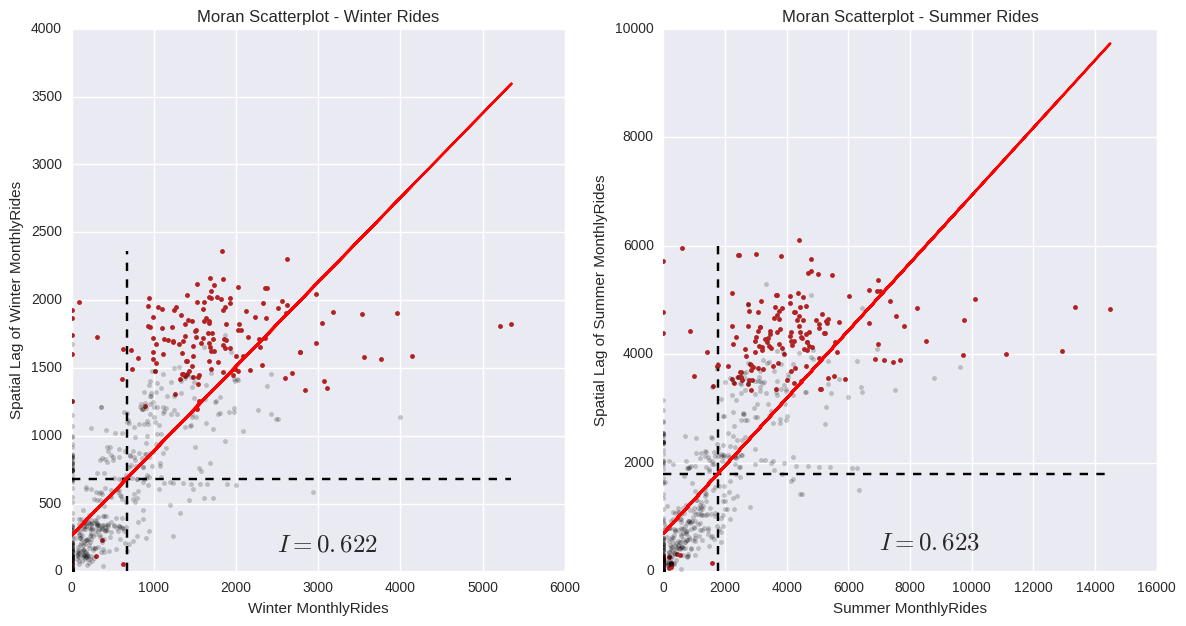

In [48]:
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    typ = collist[i]
    axs[i].plot(sigs[typ], W_sigs[typ], '.', color='firebrick')
    axs[i].plot(insigs[typ], W_insigs[typ], '.k', alpha=.2)

    # dashed vert at mean of the last year's PCI
    axs[i].vlines(MonthlyRide[typ].mean(), MonthlyRideLag[typ].min(), MonthlyRideLag[typ].max(), linestyle='--')
    # dashed horizontal at mean of lagged PCI
    axs[i].hlines(MonthlyRideLag[typ].mean(), MonthlyRide[typ].min(), MonthlyRide[typ].max(), linestyle='--')

    # red line of best fit using global I as slope
    axs[i].plot(MonthlyRide[typ], a[typ] + b[typ] * MonthlyRide[typ], 'r')

    axs[i].set_title('Moran Scatterplot - {} Rides'.format(typ))
    axs[i].set_ylabel('Spatial Lag of {} MonthlyRides'.format(typ))
    axs[i].set_xlabel('{} MonthlyRides'.format(typ))
axs[0].text(s='$I = %.3f$' % I_MonthlyRide[collist[0]].I, x=2500, y=150, fontsize=18)
#axs[1].set_title('Moran Scatterplot - Total Rides')
#axs[1].set_ylabel('Spatial Lag of Total MonthlyRides')
#axs[1].set_xlabel('Total MonthlyRides')
axs[1].text(s='$I = %.3f$' % I_MonthlyRide[collist[1]].I, x=7000, y=400, fontsize=18)


Figure 8. Moran scatterplot showing hot tracts in red and cold tracts in grey for winter rides (left) and summer rides (right).

### Hot and Cold spots 

In [49]:
sig = {}
hotspots = {}
coldspots = {}
for typ in collist:
    sig[typ] = LMo_MonthlyRide[typ].p_sim < 0.01
    hotspots[typ] = LMo_MonthlyRide[typ].q == 1 * sig[typ]
    coldspots[typ] = LMo_MonthlyRide[typ].q == 3 * sig[typ]
    print "Number of ", typ, " Hotspots:", hotspots[typ].sum()
    print "Number of ", typ, " Coldspots:", coldspots[typ].sum()

Number of  Winter  Hotspots: 195
Number of  Winter  Coldspots: 187
Number of  Summer  Hotspots: 207
Number of  Summer  Coldspots: 210


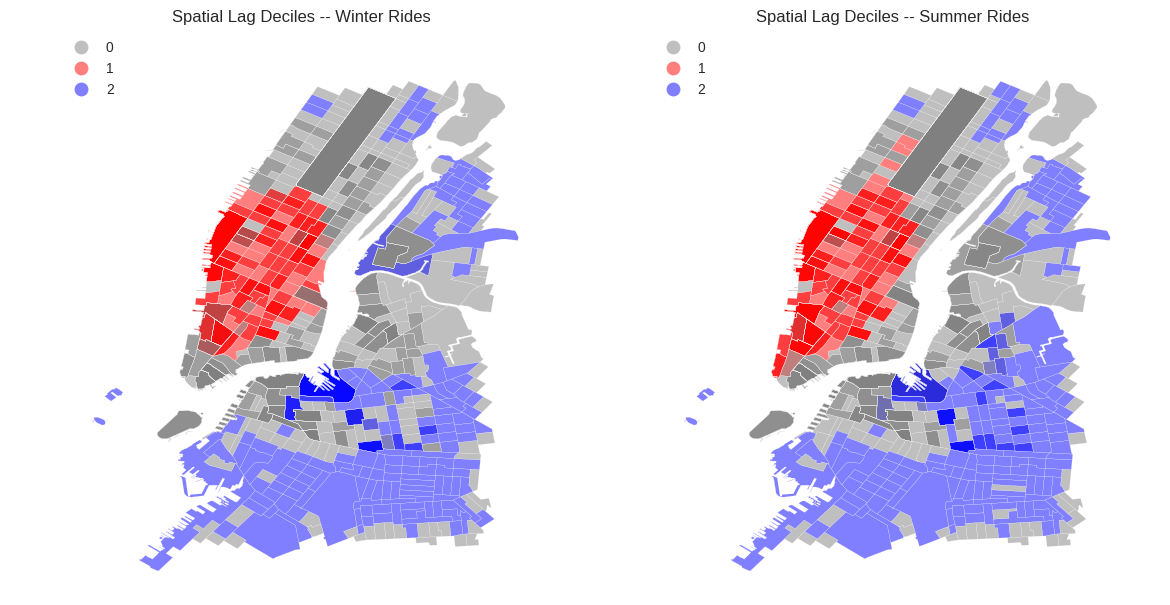

In [50]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
f, (axs[0], axs[1]) = plt.subplots(ncols=2, figsize=(14, 7))
for i in 0, 1:
    typ = collist[i]
    hotcold = hotspots[typ] * 1 + coldspots[typ] * 2

    ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
            k=10, cmap=hcmap, linewidth=0.1, ax=axs[i], 
            edgecolor='white', legend=True)
    axs[i].set_axis_off()
axs[0].set_title("Spatial Lag Deciles -- Winter Rides")
axs[1].set_title("Spatial Lag Deciles -- Summer Rides")

Figure 9. Hot/cold spot maps for winter ridership (left) and summer ridership (right) by tract.